# What drives the price of a used car?

## Overview

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### Deliverables

After understanding, preparing, and modeling your data, write up a basic report that details your primary findings. Your audience for this report is a group of used car dealers interested in fine-tuning their inventory.

## The CRISP-DM Framework

### Intro and Diagram

To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

<center>
    <img src = images/crisp.png width = 35%/>
</center>

### CRISP-DM Tasks

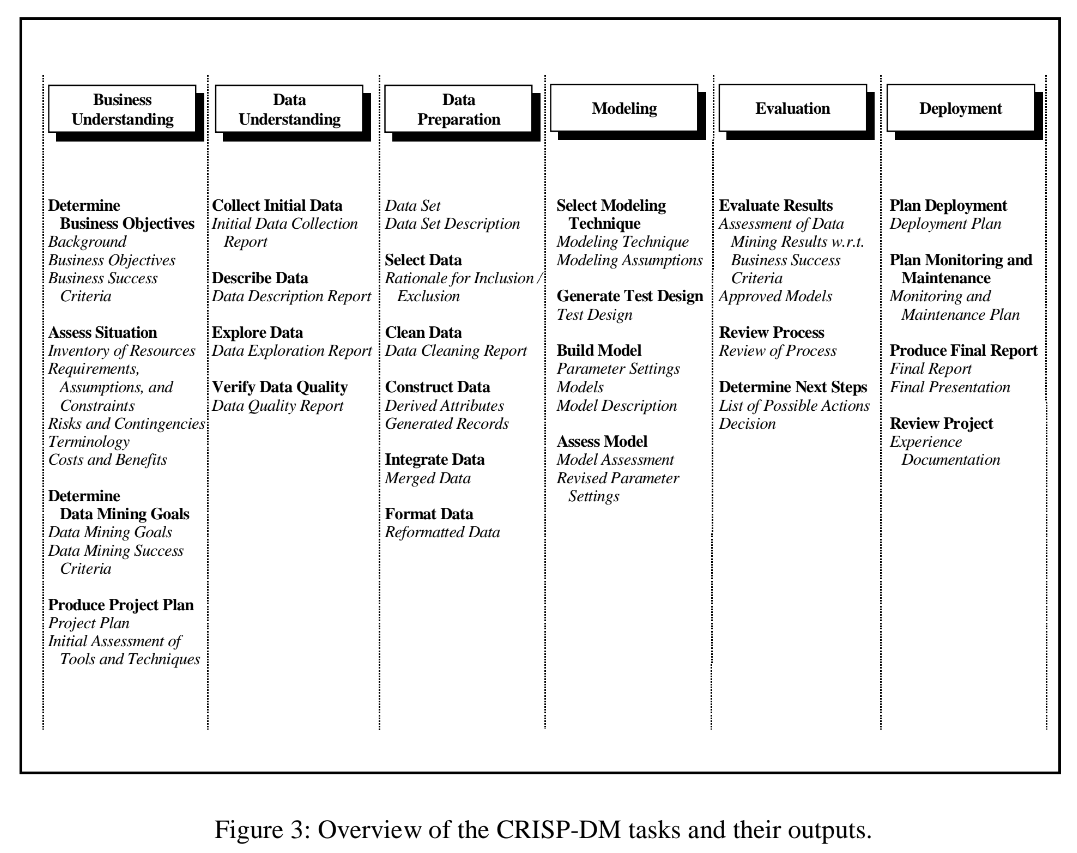

# Imports

In [1]:
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.express as px
import os
from itertools import cycle, islice

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import (
    PolynomialFeatures,
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder,
    TargetEncoder,
    PowerTransformer,
)

from sklearn.compose import (
    make_column_transformer,
    TransformedTargetRegressor,
)
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    root_mean_squared_error,
    PredictionErrorDisplay,
    mean_absolute_error,
    r2_score,
)

from IPython.display import Image

import seaborn as sns

In [2]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
plt.rcParams.update({"axes.grid": True, "figure.figsize": (16, 4)})
sns.set()

# Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary.

>This initial phase focuses on understanding the project objectives and requirements from a business perspective, and then converting this knowledge into a data mining problem definition, and a preliminary project plan designed to achieve the objectives.

## Business Objective

The business objective is to ultimately to run a more profitable used-car dealership
- To do so, they want to know what a given car would likely sell for
    - And therefore how much they can buy it for
- So that the difference meets a profit requirement
- They also want to know what specific features in a vehicle consumers most value
    - So they can look for and select those

In an ideal use case, the dealer would
- Plug a candidate vehicle's parameters into the model to obtain its probable sale price
- Derate by their profit requirement to obtain the maximum purchase price
- Purchase the vehicle for no more than the derated price
- Sell it at the predicted price, and earn the profit

## Resource Inventory

The resource inventory is
- A data set from Kaggle containing hundreds of thousands of records of prior car sales

## Data Mining Goals

The data mining goals are
- To determine what features matter when predicting car price
- To select a minimal set which achieves a stated level of accuracy
- To choose a model that when operated against these features is accurate at predicting car prices

## Success Criteria

The success criteria are
- Given a set of features, predict the car price on average within **$3,000**
    - $3000 is madeup, but call it a target for now
    - The error is assessed against the mean absolute error (MAE) over development set

# Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

>The data understanding phase starts with an initial data collection and proceeds with activities in order to get familiar with the data, to identify data quality problems, to discover first insights into the data, or to detect interesting subsets to form hypotheses for hidden information. There is a close link between Business Understanding and Data Understanding. The formulation of the data mining problem and the project plan require at least some understanding of the available data.

## Expected Steps

To get to know the data set, and identify any quality issues with it, I anticipate performing the following steps
- Load the data in and display the first few records
- Check for missing or invalid data
- Make plots of individual features and pair plots to understand what correlates with the target feature

## Data Collection and Description

The collection is a given as it was provided. The data consists of about 425,00 records, each record describes
- Where the car sale was
- For what price it sold
- The vehicle identification number (VIN)
- The year, condition, and mileage of the car
- The make and model

## Data Exploration

- Display some rows
- Check for nulls
- Make some plots
- What correlates with price?

### Data Load

In [3]:
vehicle_file_cropped = "./data/vehicles_no_nulls_shuffled.csv"
if not os.path.exists(vehicle_file_cropped):
    # Read full data set and save a cropped version - no nans
    df = pd.read_csv("./data/vehicles.csv")
    df = df.dropna().sample(frac=1.0, random_state=19)
    df.to_csv(vehicle_file_cropped, index=False)

# Read back the cropped, no nulls table
df = pd.read_csv(vehicle_file_cropped)

### Display Some Rows, Check Value Ranges, and Null Counts

There are no nulls because I cropped the data set above

In [4]:
df

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7316155043,fort wayne,54900,2019.0,ram,3500 4x4 cummins,excellent,6 cylinders,diesel,55822.0,clean,automatic,3C7WR9CL5KG517631,4wd,full-size,pickup,black,in
1,7314820840,south florida,1,2016.0,nissan,370z,excellent,6 cylinders,gas,19141.0,clean,other,JN1AZ4EH6GM937103,rwd,mid-size,coupe,black,fl
2,7312786878,myrtle beach,0,2012.0,ford,f-250 sd,good,8 cylinders,gas,28256.0,clean,automatic,1FDBF2B61CEC57787,4wd,full-size,truck,custom,sc
3,7303413468,rochester,9900,2017.0,ford,focus titanium,excellent,4 cylinders,gas,26850.0,salvage,automatic,1FADP3J22HL281300,fwd,compact,sedan,black,mn
4,7314820999,south florida,1,2019.0,ram,3500,excellent,6 cylinders,gas,48785.0,clean,other,3C63RRHL7KG625247,4wd,full-size,truck,white,fl
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34863,7316378796,eau claire,3995,2011.0,ford,fusion,excellent,4 cylinders,gas,207000.0,clean,automatic,3FAHP08A5BR256025,fwd,mid-size,sedan,silver,wi
34864,7313931468,south jersey,13599,2016.0,hyundai,santa fe sport,excellent,4 cylinders,gas,153383.0,clean,automatic,5XYZUDLB7GG321408,4wd,full-size,SUV,black,nj
34865,7314820305,madison,22487,2017.0,ford,transit van,good,6 cylinders,gas,84114.0,clean,automatic,1FTYE1ZM2HKB17885,rwd,mid-size,van,white,wi
34866,7306917244,grand rapids,47990,2014.0,ford,super duty f-550 drw,good,8 cylinders,diesel,39253.0,clean,automatic,1FDUF5HT8EEA80861,4wd,full-size,truck,white,mi


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34868 entries, 0 to 34867
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            34868 non-null  int64  
 1   region        34868 non-null  object 
 2   price         34868 non-null  int64  
 3   year          34868 non-null  float64
 4   manufacturer  34868 non-null  object 
 5   model         34868 non-null  object 
 6   condition     34868 non-null  object 
 7   cylinders     34868 non-null  object 
 8   fuel          34868 non-null  object 
 9   odometer      34868 non-null  float64
 10  title_status  34868 non-null  object 
 11  transmission  34868 non-null  object 
 12  VIN           34868 non-null  object 
 13  drive         34868 non-null  object 
 14  size          34868 non-null  object 
 15  type          34868 non-null  object 
 16  paint_color   34868 non-null  object 
 17  state         34868 non-null  object 
dtypes: float64(2), int64(2), o

In [6]:
df.loc[:, df.dtypes == "object"]

,region,manufacturer,model,condition,cylinders,fuel,title_status,transmission,VIN,drive,size,type,paint_color,state
0,fort wayne,ram,3500 4x4 cummins,excellent,6 cylinders,diesel,clean,automatic,3C7WR9CL5KG517631,4wd,full-size,pickup,black,in
1,south florida,nissan,370z,excellent,6 cylinders,gas,clean,other,JN1AZ4EH6GM937103,rwd,mid-size,coupe,black,fl
2,myrtle beach,ford,f-250 sd,good,8 cylinders,gas,clean,automatic,1FDBF2B61CEC57787,4wd,full-size,truck,custom,sc
3,rochester,ford,focus titanium,excellent,4 cylinders,gas,salvage,automatic,1FADP3J22HL281300,fwd,compact,sedan,black,mn
4,south florida,ram,3500,excellent,6 cylinders,gas,clean,other,3C63RRHL7KG625247,4wd,full-size,truck,white,fl
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34863,eau claire,ford,fusion,excellent,4 cylinders,gas,clean,automatic,3FAHP08A5BR256025,fwd,mid-size,sedan,silver,wi
34864,south jersey,hyundai,santa fe sport,excellent,4 cylinders,gas,clean,automatic,5XYZUDLB7GG321408,4wd,full-size,SUV,black,nj
34865,madison,ford,transit van,good,6 cylinders,gas,clean,automatic,1FTYE1ZM2HKB17885,rwd,mid-size,van,white,wi
34866,grand rapids,ford,super duty f-550 drw,good,8 cylinders,diesel,clean,automatic,1FDUF5HT8EEA80861,4wd,full-size,truck,white,mi


#### Most common manufacturers

Ford and Chevrolet

In [7]:
df["manufacturer"].value_counts().sort_values(ascending=False).tail(10)

manufacturer
jaguar             87
mercury            86
fiat               49
tesla              19
alfa-romeo         15
ferrari            10
harley-davidson     7
datsun              3
aston-martin        3
land rover          2
Name: count, dtype: int64

#### Most Common Models Across all Brands

The f-150 and chevrolet silverado, both pickup trucks

In [8]:
df["model"].value_counts().sort_values(ascending=False).head(10)

model
f-150                   943
silverado 1500          929
1500                    482
2500                    332
sierra 1500             330
silverado 2500hd        298
escape                  251
super duty f-550 drw    247
sierra 2500hd           247
tacoma                  246
Name: count, dtype: int64

#### Most Popular Vehicle Types

SUV's and sedans. Seems somewhat in conflict the top 10 listing above, which shows 9 of the 10 most common are pickup trucks.

In [9]:
df["type"].value_counts().sort_values(ascending=False).head(10)

type
SUV            9278
sedan          8249
truck          7692
pickup         2764
van            1754
coupe          1493
hatchback      1133
wagon           837
convertible     824
mini-van        619
Name: count, dtype: int64

#### Most Popular Honda Models

In [10]:
df.query("manufacturer == 'honda'")["model"].value_counts()

model
cr-v                    180
civic                   176
accord                  163
odyssey                 125
pilot                   123
                       ... 
accord ex-l v6 sedan      1
cr-v 4                    1
element ex-p awd          1
accord ex-l navi          1
civic del sol si          1
Name: count, Length: 233, dtype: int64

### What Correlates with Price?

Not much of anything directly correlates with price

In [11]:
df.corr(numeric_only=True)["price"].sort_values(ascending=False)

price       1.000000
year        0.254059
id         -0.049819
odometer   -0.199988
Name: price, dtype: float64

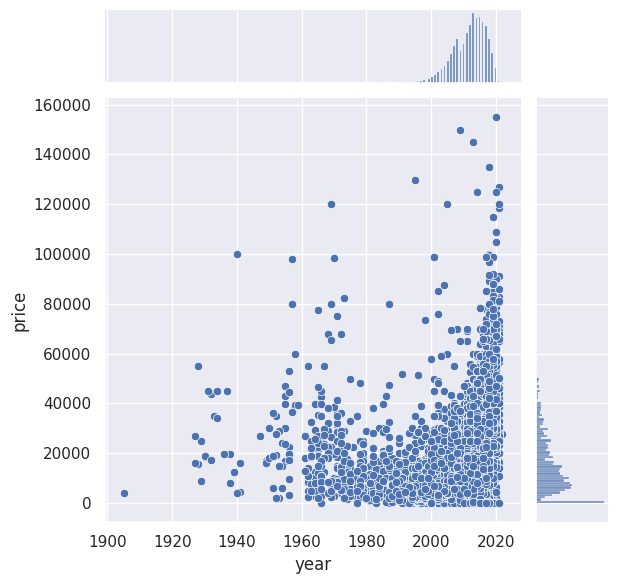

In [12]:
sns.jointplot(df, x="year", y="price")

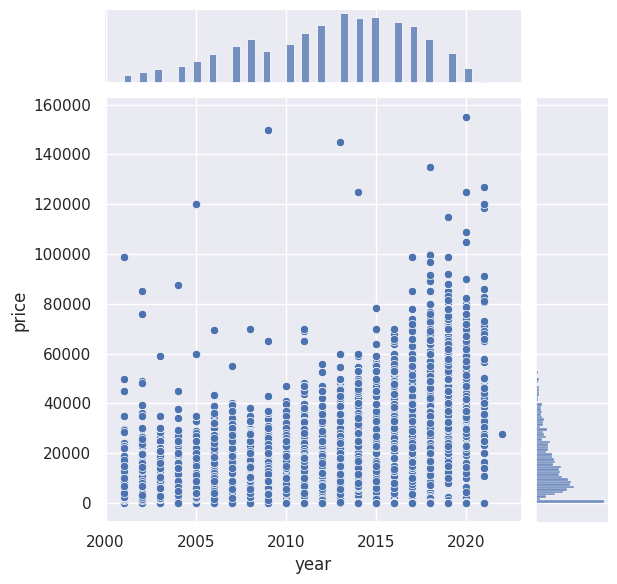

In [13]:
sns.jointplot(df.query("year > 2000"), x="year", y="price")

### Make Some Plots

In the distribution plots, I am showing the distribution for a feature, recognizing there are very long tails, and then showing that same distribution again after these tails have been cropped.

#### Pair Plots

Neither the year nor odomoter correlate with price on their own.

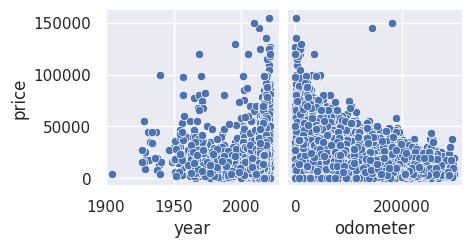

In [14]:
x_vars = ["year", "odometer"]
y_vars = ["price"]
sns.pairplot(df.query("odometer < 300_000"), x_vars=x_vars, y_vars=y_vars)

#### Price

In [15]:
def sns_histplot(data: pd.DataFrame, x: str = ""):
    sns.histplot(
        data=data,
        x=x,
        kde=True,
        palette=sns.color_palette("bright")[:3],
    )

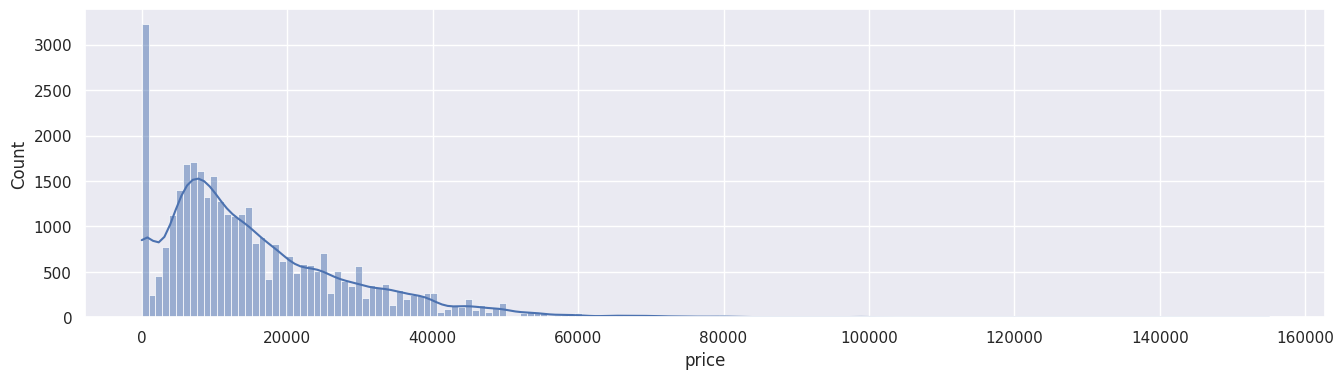

In [16]:
sns_histplot(df, x="price")

In [17]:
df[["price"]].describe()

,price
count,34868.000000
mean,15837.446771
std,13460.056823
min,0.000000
25%,6500.000000
50%,12000.000000
75%,22003.500000
max,155000.000000


In [18]:
[(df["price"] == 0).sum(), (df["price"] > 50000).sum()]

[2372, 669]

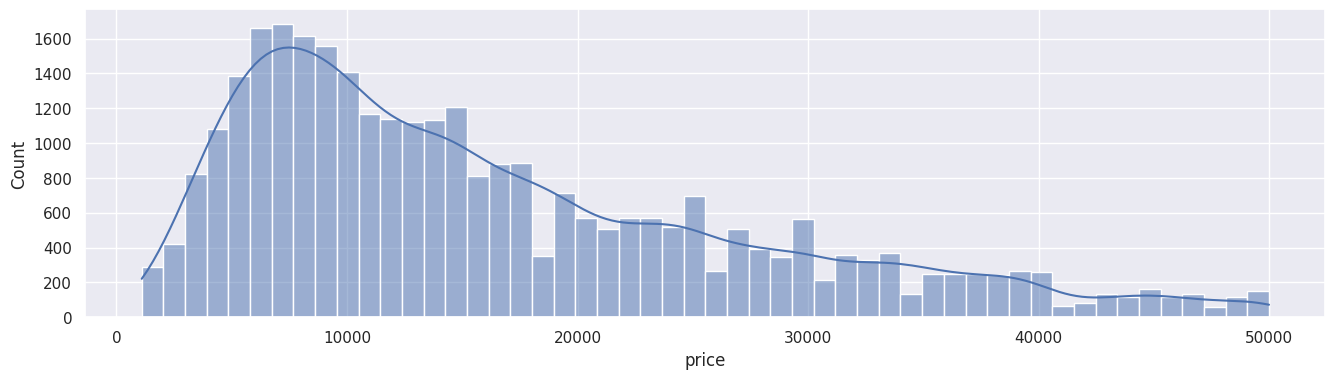

In [19]:
sns_histplot(df.query("price > 1_000 and price < 50000"), x="price")

#### Odomoter

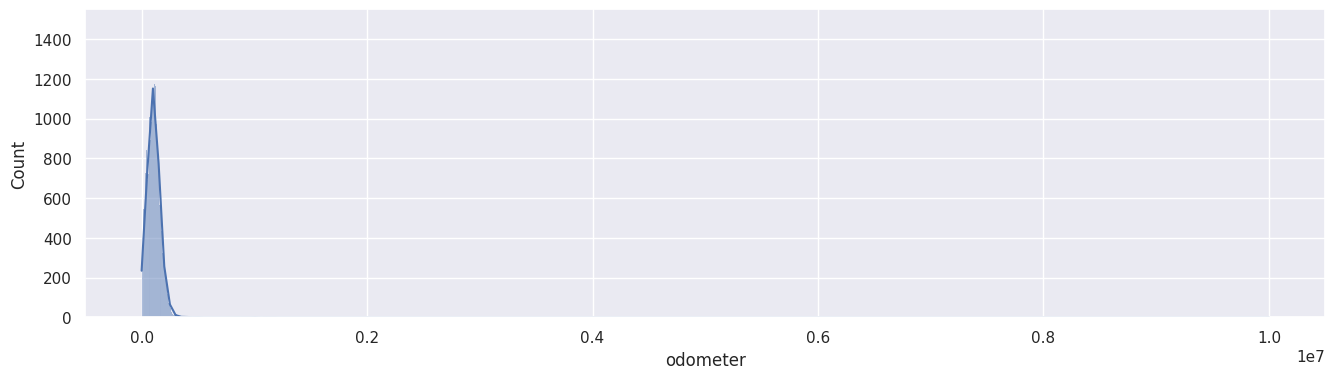

In [20]:
sns_histplot(df, x="odometer")

In [21]:
df[["odometer"]].describe()

,odometer
count,3.486800e+04
mean,1.073991e+05
std,9.990878e+04
min,0.000000e+00
25%,6.516400e+04
50%,1.040000e+05
75%,1.411678e+05
max,9.999999e+06


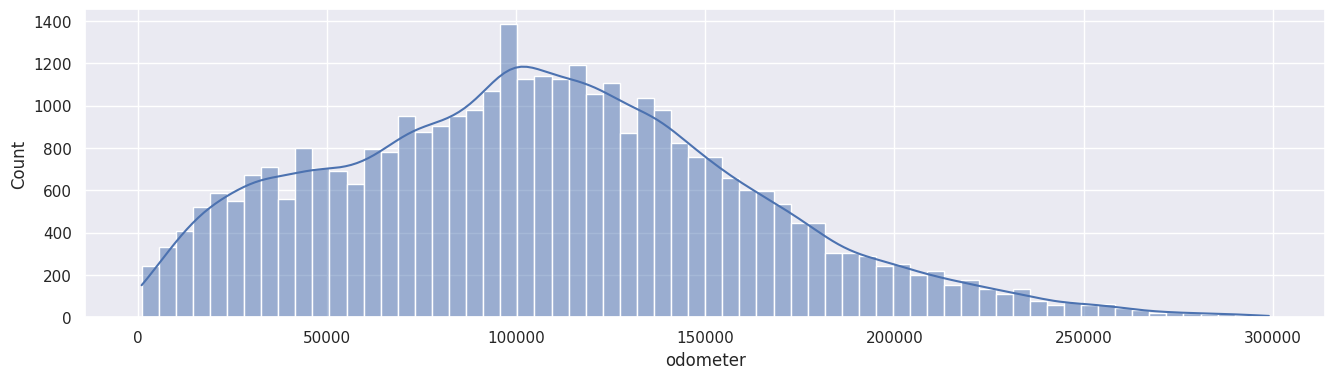

In [22]:
sns_histplot(df[(df["odometer"] > 1000) & (df["odometer"] < 300_000)], x="odometer")

#### Year

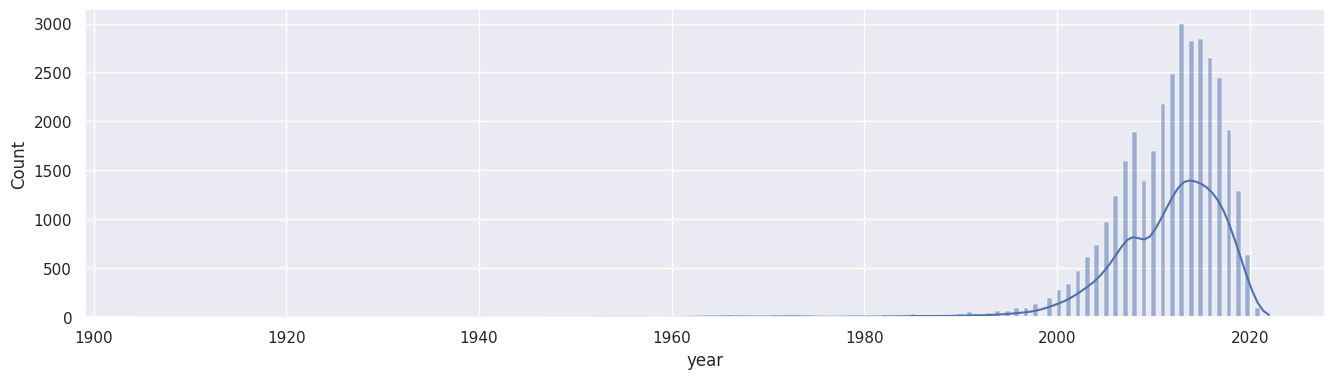

In [23]:
sns_histplot(df, x="year")

In [24]:
df[["year"]].describe()

,year
count,34868.000000
mean,2011.176867
std,7.162332
min,1905.000000
25%,2008.000000
50%,2013.000000
75%,2016.000000
max,2022.000000


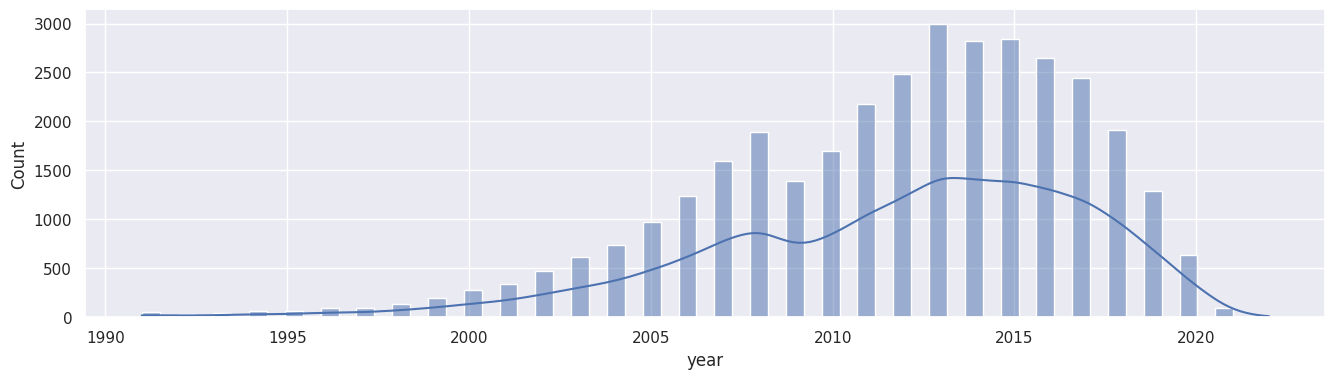

In [25]:
sns_histplot(df[(df["year"] > 1990)], x="year")

### Observations & Adjudications

#### Drop These

Column|Why Drop
---|---
id|Junk number
VIN|Junk number (although VIN does encode year, manufacturer, other stuff...)

#### Keep These

Feature|Limit (All are Arbitrary)|Transform
---|---|---
price|1_000, 50_000|None
odometer|1_000, 300_000|Poly
year|>1990|Poly
manufacturer|High cardinality - can collapse into lux and basic and then ordinal?|Target
model|High cardinality - combine with manufacturer to form a synthetic feature|Target
cylinders|None|Ohe
title_status|None|Ohe (ostensibly this is ordinal, but how to decide?)
state|None|Target
region|Combine with state|Target
transmission|None|Ohe
fuel|None|Ohe
paint_color|None|Ohe
condition|None|Ordinal, because excellent > good > salvage

## Verify Data Quality

I think the idea here is to sanity check the data set, perhaps in the event that someone formed an aggregate by pulling from multiple sources
- Can do some range plots checks again and verify something like price makes sense
- But essentially have already done that above

# Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`.  

>The data preparation phase covers all activities to construct the final dataset (data that will be fed into the modeling tool(s)) from the initial raw data. Data preparation tasks are likely to be performed multiple times, and not in any prescribed order. Tasks include table, record, and attribute selection, data cleaning, construction of new attributes, and transformation of data for modeling tools.

## Cleaning / Dropping / Deleting

From the above exploration, the price, odometer, and year ranges are cropped down
- Features that will be ignored are not explicitly dropped
- Instead, they are never used in the column transformers

### Limit the Data

In [26]:
mask = (
    df["price"].between(1_000, 50_000, inclusive="neither")
    & df["odometer"].between(1_000, 300_000, inclusive="neither")
    & df["year"].gt(1990)
)

In [27]:
target_feature = "price"

In [28]:
X = df[mask].drop(columns=[target_feature])
y = df[mask][target_feature]

In [29]:
y.describe()

count    30110.000000
mean     16500.836832
std      11019.060388
min       1095.000000
25%       7990.000000
50%      13500.000000
75%      22995.000000
max      49999.000000
Name: price, dtype: float64

## Feature Development

An ordinal set is defined for the condition feature

In [30]:
X["condition"].unique()

array(['excellent', 'good', 'like new', 'fair', 'new', 'salvage'],
      dtype=object)

In [31]:
condition_categories = [
    "new",
    "like new",
    "excellent",
    "good",
    "fair",
    "salvage",
]

Make and model are combined to form the high-cardinality feature make-model

In [32]:
X.insert(
    loc=X.columns.get_loc("model") + 1,
    column="make-model",
    value=X["manufacturer"] + " " + X["model"],
)

State and region are combined to form the high-cardinality feature stage-region

In [33]:
X.insert(
    loc=X.columns.get_loc("region") + 1,
    column="state-region",
    value=X["state"] + " " + X["region"],
)

In [34]:
X

,id,region,state-region,year,manufacturer,model,make-model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
3,7303413468,rochester,mn rochester,2017.0,ford,focus titanium,ford focus titanium,excellent,4 cylinders,gas,26850.0,salvage,automatic,1FADP3J22HL281300,fwd,compact,sedan,black,mn
5,7314409838,ventura county,ca ventura county,2014.0,ford,e250 super duty cargo,ford e250 super duty cargo,excellent,8 cylinders,gas,65695.0,clean,automatic,1FTNE2EWXEDA13774,rwd,full-size,van,white,ca
6,7315439972,denver,co denver,2008.0,pontiac,torrent,pontiac torrent,good,6 cylinders,gas,221618.0,clean,automatic,2CKDL43F886056750,4wd,mid-size,SUV,yellow,co
7,7315295791,reno / tahoe,ca reno / tahoe,2008.0,pontiac,g6,pontiac g6,excellent,6 cylinders,gas,127600.0,clean,automatic,1G2ZG57N884113477,fwd,compact,sedan,silver,ca
8,7315499219,brownsville,tx brownsville,2007.0,gmc,sierra sle 1500,gmc sierra sle 1500,like new,8 cylinders,gas,167000.0,clean,automatic,1GCECT24LKJH73951,rwd,full-size,pickup,white,tx
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34863,7316378796,eau claire,wi eau claire,2011.0,ford,fusion,ford fusion,excellent,4 cylinders,gas,207000.0,clean,automatic,3FAHP08A5BR256025,fwd,mid-size,sedan,silver,wi
34864,7313931468,south jersey,nj south jersey,2016.0,hyundai,santa fe sport,hyundai santa fe sport,excellent,4 cylinders,gas,153383.0,clean,automatic,5XYZUDLB7GG321408,4wd,full-size,SUV,black,nj
34865,7314820305,madison,wi madison,2017.0,ford,transit van,ford transit van,good,6 cylinders,gas,84114.0,clean,automatic,1FTYE1ZM2HKB17885,rwd,mid-size,van,white,wi
34866,7306917244,grand rapids,mi grand rapids,2014.0,ford,super duty f-550 drw,ford super duty f-550 drw,good,8 cylinders,diesel,39253.0,clean,automatic,1FDUF5HT8EEA80861,4wd,full-size,truck,white,mi


## Data Transformations

Scaling, logs, normalizing
- Scaling / normalizing is done inside the model pipelines
    - The input to the poly features
    - And the output of the feature union are standardized
- Transformations are also done in the pipeline
    - A power transformer is used to limit outliers from the prediction

In [35]:
if 0:
    X_copy = X[["manufacturer"]].copy(deep=True)
    X_copy["manufacturer_te"] = TargetEncoder(
        smooth="auto", random_state=42, target_type="continuous"
    ).fit_transform(X[["manufacturer"]], y)
    X_copy = (
        X_copy.groupby("manufacturer")
        .agg("mean")
        .sort_values(by="manufacturer_te", ascending=False)
    )
    # display(X_copy)
    plt.figure(figsize=(9, 16))
    sns.barplot(X_copy, y=X_copy.index, x=X_copy["manufacturer_te"], orient="h")

# Modeling

With your almost final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.  

>In this phase, various modeling techniques are selected and applied, and their parameters are calibrated to optimal values. Typically, there are several techniques for the same data mining problem type. Some techniques require specific data formats. There is a close link between Data Preparation and Modeling. Often, one realizes data problems while modeling or one gets ideas for constructing new data.

## Train / Test Split

75/25 is arbitrary

In [36]:
(X_train, X_dev, y_train, y_dev, idx_train, idx_dev) = train_test_split(
    X, y, range(len(X)), random_state=42, train_size=0.75
)

## Model Helpers

In [37]:
def compute_score(y_true, y_pred):
    return {
        "R2": f"{r2_score(y_true, y_pred):.3f}",
        "Mean AE": round(mean_absolute_error(y_true, y_pred)),
        "RMSE": round(root_mean_squared_error(y_true, y_pred)),
    }

The following is adapted from [this example](https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html#sphx-glr-auto-examples-compose-plot-transformed-target-py)

In [38]:
def make_PredictionErrorDisplay_plot(
    estimator: Pipeline = None,
    description: str = "",
):
    f, ax = plt.subplots(2, 2, sharex=True, figsize=(16, 12))

    for k in range(2):
        ax_row = ax[k]
        if k == 0:
            y_true, y_pred = y_train, estimator.predict(X_train)
        else:
            y_true, y_pred = y_dev, estimator.predict(X_dev)

        # Plot the actual vs predicted values
        PredictionErrorDisplay.from_predictions(
            y_true,
            y_pred,
            kind="actual_vs_predicted",
            ax=ax_row[0],
            scatter_kwargs={"alpha": 0.5},
        )

        ax_row[0].set_title(
            "%s Actual vs. Predicted\nErrors: %s"
            % ("Train" if k == 0 else "Dev", str(compute_score(y_true, y_pred)))
        )

        # plot the residuals vs the predicted values
        PredictionErrorDisplay.from_predictions(
            y_true,
            y_pred,
            kind="residual_vs_predicted",
            ax=ax_row[1],
            scatter_kwargs={"alpha": 0.5},
        )

        ax_row[1].set_title(
            "%s Residual vs. Predicted" % ("Train" if k == 0 else "Dev")
        )

    plt.suptitle(
        description,
        fontsize=16,
        fontweight="bold",
        ha="center",
    )

    plt.tight_layout()
    plt.show()

In [39]:
param_grid = {}
if param_grid:
    display("hi param_grid")
else:
    display("bye!")

'bye!'

In [40]:
def grid_search_and_plot(
    estimator: Pipeline = None,
    param_grid: dict = {},
    description: str = "",
):
    if param_grid:
        # Run the grid search
        grid_search = GridSearchCV(
            estimator=estimator,
            param_grid=param_grid,
            scoring="neg_mean_squared_error",
            cv=[[idx_train, idx_dev]],  # hold out
            # cv=5, # kfold
        ).fit(
            X, y
        )  # using all X, y not training partition, because cv does the split for us

        display(grid_search.best_params_)

        # Get best estimator
        best_estimator = grid_search.best_estimator_
    else:
        best_estimator = estimator

    # Fit
    best_estimator.fit(X_train, y_train)

    # Make some performance plots
    make_PredictionErrorDisplay_plot(
        estimator=best_estimator,
        description=description,
    )

    return best_estimator

## Model 1 - Establish a Baseline

Attributes
- Linear regression in year and odometer
- No optimization

### Define

In [41]:
poly_pipe = Pipeline(
    [
        (
            "scaler",
            make_column_transformer(
                (
                    StandardScaler(),
                    ["year", "odometer"],
                ),
            ),
        ),
        (
            "poly",
            PolynomialFeatures(degree=1, include_bias=False),
        ),
    ]
)

# poly_pipe

In [42]:
model1 = Pipeline(
    [
        ("transform", poly_pipe),
        ("regression", LinearRegression(fit_intercept=True)),
    ]
)

### Plot

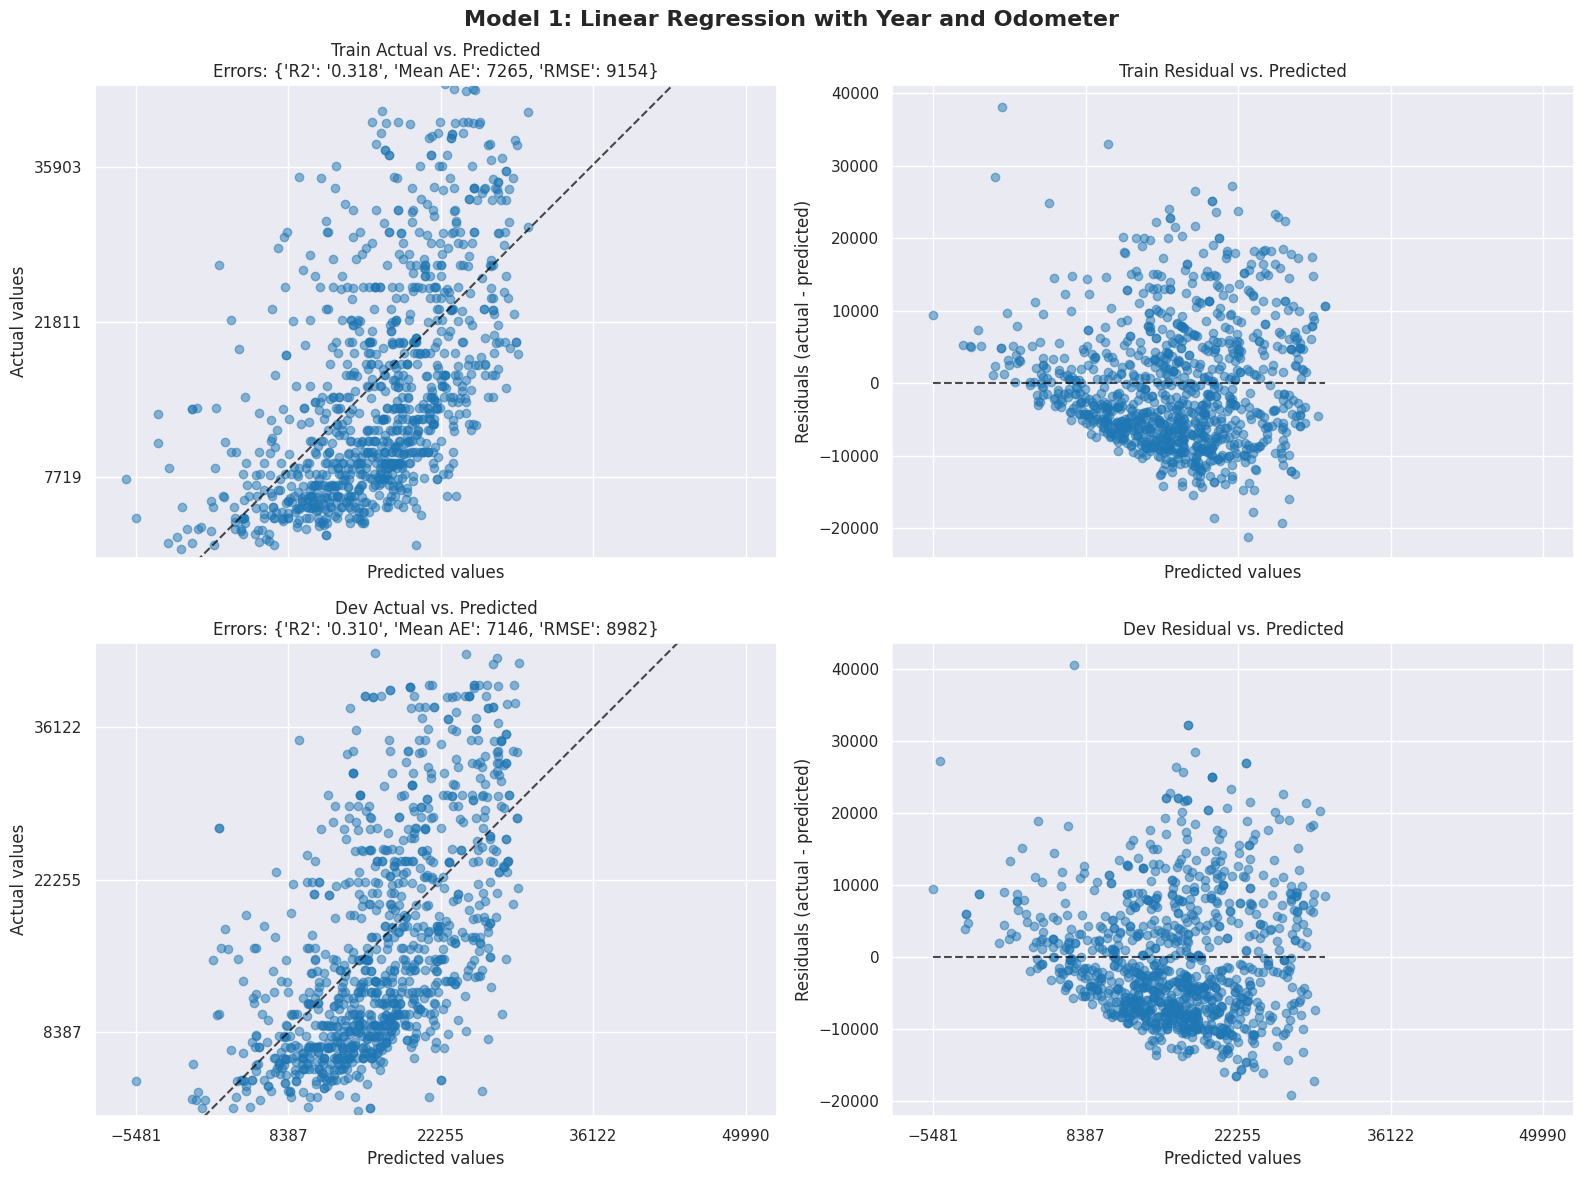

Pipeline(steps=[('transform',
                 Pipeline(steps=[('scaler',
                                  ColumnTransformer(transformers=[('standardscaler',
                                                                   StandardScaler(),
                                                                   ['year',
                                                                    'odometer'])])),
                                 ('poly',
                                  PolynomialFeatures(degree=1,
                                                     include_bias=False))])),
                ('regression', LinearRegression())])

In [43]:
grid_search_and_plot(
    estimator=model1,
    description="Model 1: Linear Regression with Year and Odometer",
)

### Analysis

The baseline model is pretty terrible. The error is more than 2x the requirement.

## Model 2 - Basic Ridge

Attributes
- Regressor is ridge
- Features are poly, ordinal, and one hot
- Scaling is applied on the transformed features (inputs to ridge) to avoid crushing large values
- Hyperparameter search with grid

### Define

In [44]:
model2_categorical_xformer = make_column_transformer(
    (
        OneHotEncoder(drop="if_binary", sparse_output=False, handle_unknown="ignore"),
        ["manufacturer"],
    ),
    (OrdinalEncoder(categories=[condition_categories]), ["condition"]),
)

In [45]:
model2_feature_union = FeatureUnion(
    [
        ("poly_pipe", poly_pipe),
        ("categorical_xformer", model2_categorical_xformer),
    ]
)

In [46]:
if 0:
    model2_feature_union.fit(X)
    display(
        pd.DataFrame(
            model2_feature_union.transform(X),
            columns=model2_feature_union.get_feature_names_out(),
        )
    )

In [47]:
model2 = Pipeline(
    [
        ("feature_union", model2_feature_union),
        ("scaler", StandardScaler()),
        ("ridge", Ridge(fit_intercept=True)),
    ]
)

### Grid Search and Plot

In [48]:
# model2_best.named_steps["feature_union"].named_transformers["poly_pipe"].named_steps["poly"].degree

In [49]:
param_grid = {
    "feature_union__poly_pipe__poly__degree": range(1, 4),
    "ridge__alpha": 10 ** np.linspace(-5, 5, 11),
}

{'feature_union__poly_pipe__poly__degree': 3,
 'ridge__alpha': 9.999999999999999e-06}

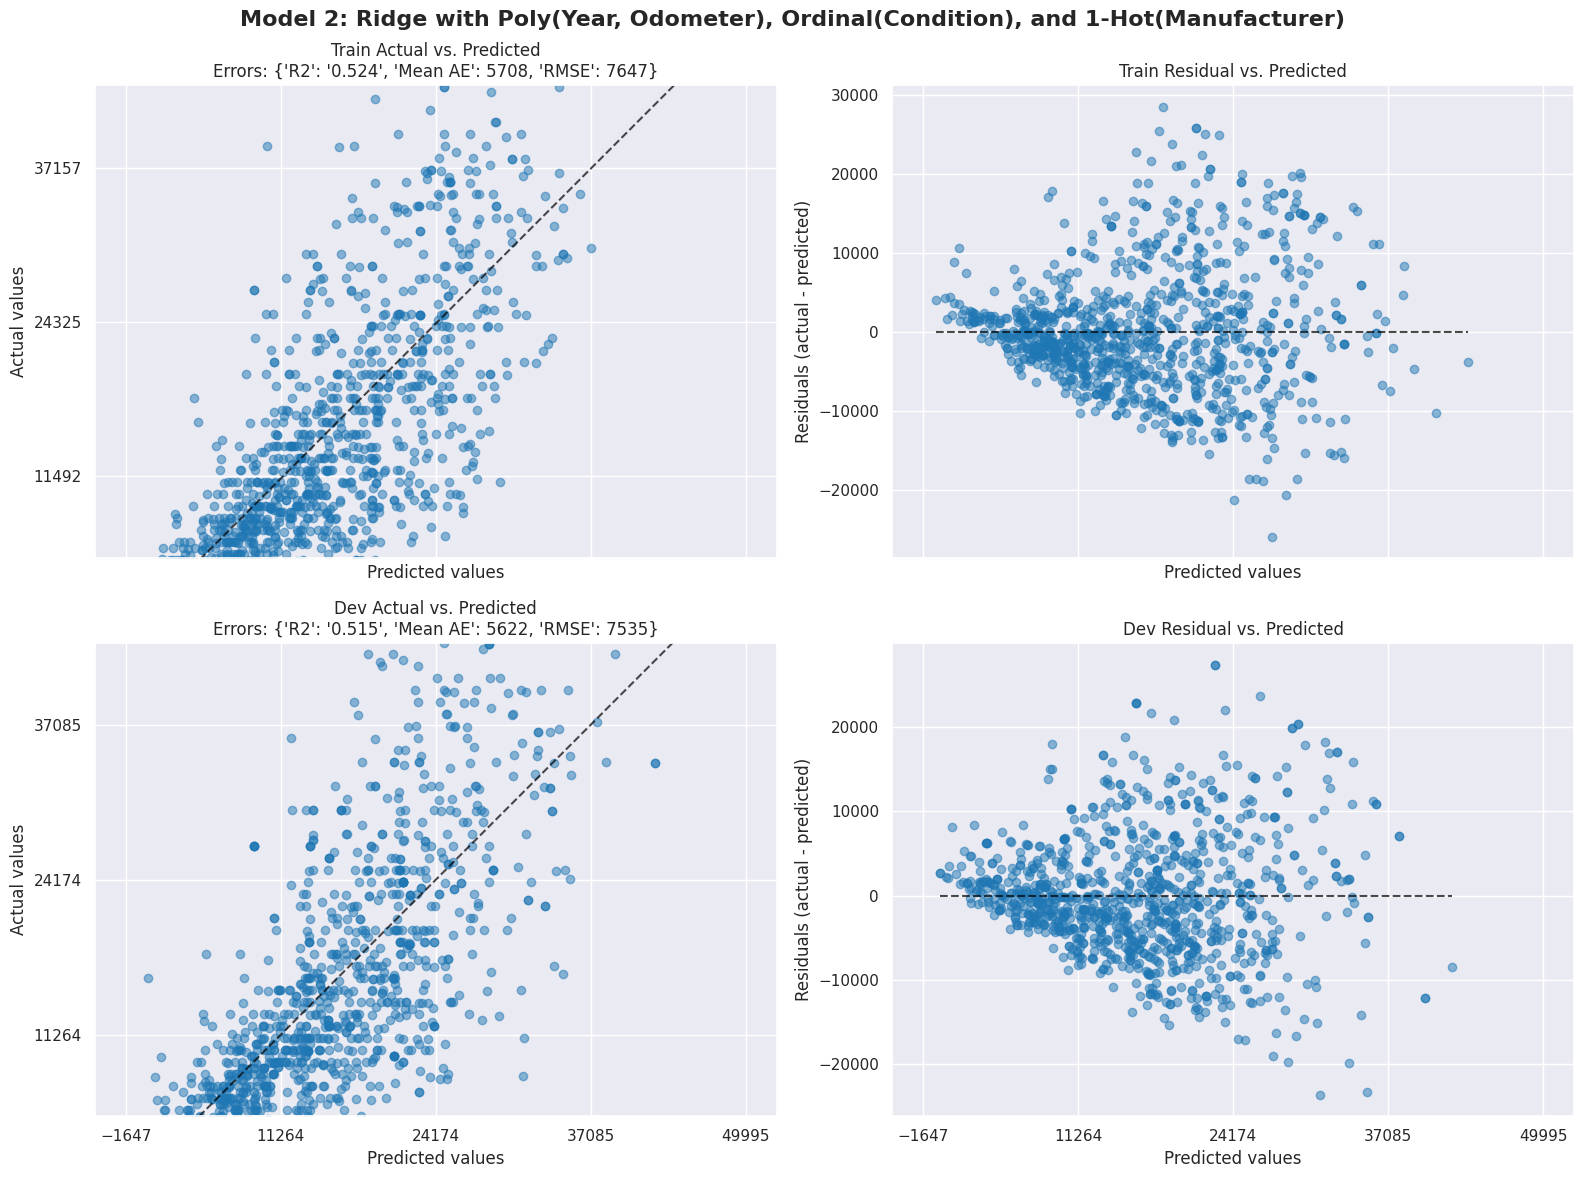

Pipeline(steps=[('feature_union',
                 FeatureUnion(transformer_list=[('poly_pipe',
                                                 Pipeline(steps=[('scaler',
                                                                  ColumnTransformer(transformers=[('standardscaler',
                                                                                                   StandardScaler(),
                                                                                                   ['year',
                                                                                                    'odometer'])])),
                                                                 ('poly',
                                                                  PolynomialFeatures(degree=3,
                                                                                     include_bias=False))])),
                                                ('categorical_xformer',
                                                 ColumnTransformer(transformers=[('onehotencoder',
                                                                                  OneHotEncoder(drop='if_binary',
                                                                                                handle_unknown='ignore',
                                                                                                sparse_output=False),
                                                                                  ['manufacturer']),
                                                                                 ('ordinalencoder',
                                                                                  OrdinalEncoder(categories=[['new',
                                                                                                              'like '
                                                                                                              'new',
                                                                                                              'excellent',
                                                                                                              'good',
                                                                                                              'fair',
                                                                                                              'salvage']]),
                                                                                  ['condition'])]))])),
                ('scaler', StandardScaler()),
                ('ridge', Ridge(alpha=9.999999999999999e-06))])

In [50]:
grid_search_and_plot(
    estimator=model2,
    param_grid=param_grid,
    description="Model 2: Ridge with Poly(Year, Odometer), Ordinal(Condition), and 1-Hot(Manufacturer)",
)

### Analysis

The ridge model with no optimization is looking better than baseline, but is not good enough. The error is still almost 2x the requirement.

## Model 2.1 - Basic Ridge with Target Encoder

Attributes
- Regressor is ridge
- Features are poly, ordinal, and **target encoder** on make-model
- Scaling is applied on the transformed features (inputs to ridge) to avoid crushing large values
- Hyperparameter search with grid


### Define

In [51]:
model2p1_categorical_xformer = make_column_transformer(
    (
        TargetEncoder(smooth="auto", random_state=42, target_type="continuous"),
        ["make-model", "state-region"],
    ),
    (OrdinalEncoder(categories=[condition_categories]), ["condition"]),
)

In [52]:
model2p1_feature_union = FeatureUnion(
    [
        ("poly_pipe", poly_pipe),
        ("categorical_xformer", model2p1_categorical_xformer),
    ]
)

In [53]:
model2p1 = Pipeline(
    [
        ("feature_union", model2p1_feature_union),
        ("scaler", StandardScaler()),
        ("ridge", Ridge(fit_intercept=True)),
    ]
)

### Grid Search and Plot

{'feature_union__poly_pipe__poly__degree': 3,
 'ridge__alpha': 0.09999999999999999}

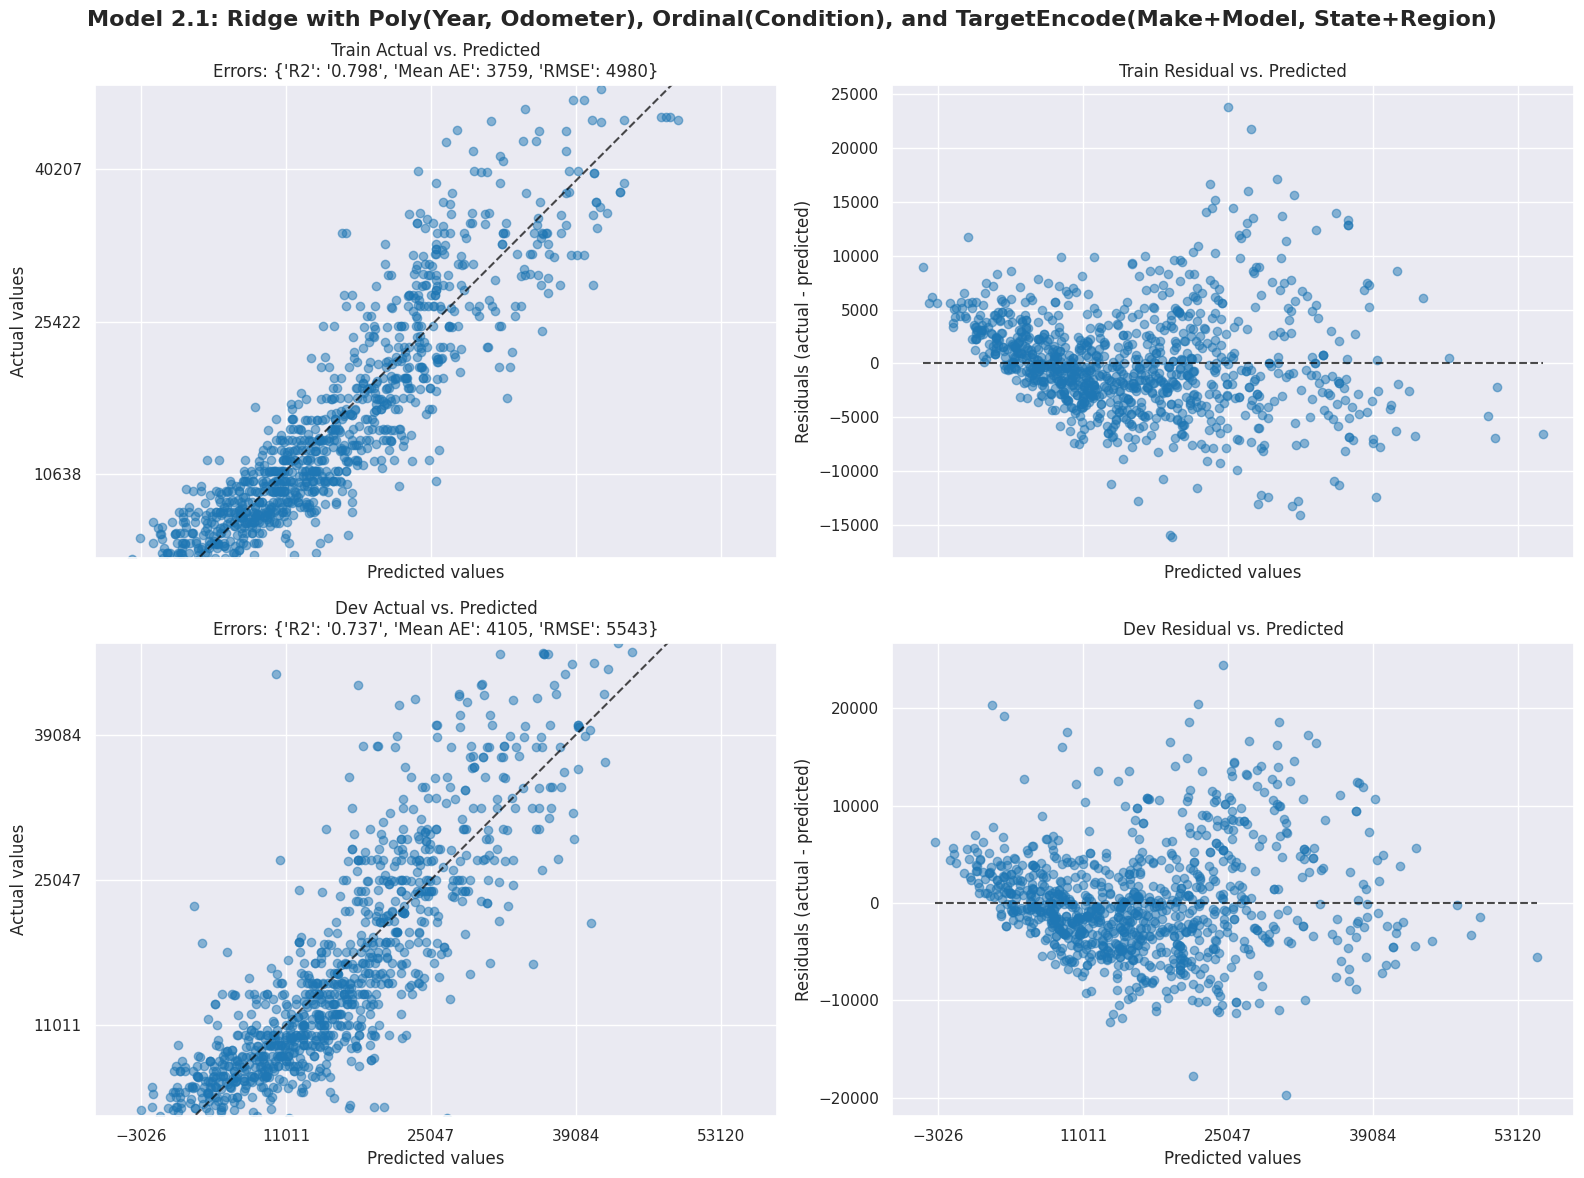

Pipeline(steps=[('feature_union',
                 FeatureUnion(transformer_list=[('poly_pipe',
                                                 Pipeline(steps=[('scaler',
                                                                  ColumnTransformer(transformers=[('standardscaler',
                                                                                                   StandardScaler(),
                                                                                                   ['year',
                                                                                                    'odometer'])])),
                                                                 ('poly',
                                                                  PolynomialFeatures(degree=3,
                                                                                     include_bias=False))])),
                                                ('categorical_xformer',
                                                 ColumnTransformer(transformers=[('targetencoder',
                                                                                  TargetEncoder(random_state=42,
                                                                                                target_type='continuous'),
                                                                                  ['make-model',
                                                                                   'state-region']),
                                                                                 ('ordinalencoder',
                                                                                  OrdinalEncoder(categories=[['new',
                                                                                                              'like '
                                                                                                              'new',
                                                                                                              'excellent',
                                                                                                              'good',
                                                                                                              'fair',
                                                                                                              'salvage']]),
                                                                                  ['condition'])]))])),
                ('scaler', StandardScaler()),
                ('ridge', Ridge(alpha=0.09999999999999999))])

In [54]:
grid_search_and_plot(
    estimator=model2p1,
    param_grid=param_grid,
    description="Model 2.1: Ridge with Poly(Year, Odometer), Ordinal(Condition), and TargetEncode(Make+Model, State+Region)",
)

### Analysis

Replacing one-hot on manufacturer with target encoding on make+model improved performance significantly.

## Model 3 - Ridge with More Features

Attributes
- Regressor continues to be ridge
- Retain the target encoder for the make+model feature
- Add all categorical features
- Include a power transformer on the output via target transformer to suppress out of family predictions

### Define

Features are never dropped explicitly, they are just not named in the transformers, so they get dropped in the fit/transform step of the pipeline

In [55]:
model3_categorical_xformer = make_column_transformer(
    (
        TargetEncoder(smooth="auto", random_state=42, target_type="continuous"),
        ["make-model", "state-region"],
    ),
    (
        OneHotEncoder(drop="if_binary", sparse_output=False, handle_unknown="ignore"),
        [
            "title_status",
            "cylinders",
            "transmission",
            "fuel",
            "type",
            "size",
            "drive",
            "paint_color",
        ],
    ),
    (OrdinalEncoder(categories=[condition_categories]), ["condition"]),
)

In [56]:
model3_feature_union = FeatureUnion(
    [
        ("poly_pipe", poly_pipe),
        ("categorical_xformer", model3_categorical_xformer),
    ]
)

In [57]:
regressor = Pipeline(
    [
        ("feature_union", model3_feature_union),
        ("scaler", StandardScaler()),
        ("ridge", Ridge(fit_intercept=True)),
    ]
)

model3 = Pipeline(
    [
        (
            "ttr",
            TransformedTargetRegressor(
                regressor=regressor,
                transformer=PowerTransformer(),
            ),
        )
    ]
)

### Grid Search and Plot

In [58]:
ttr_param_grid = {
    "ttr__regressor__feature_union__poly_pipe__poly__degree": range(1, 4),
    "ttr__regressor__ridge__alpha": 10 ** np.linspace(-5, 5, 21),
}

{'ttr__regressor__feature_union__poly_pipe__poly__degree': 3,
 'ttr__regressor__ridge__alpha': 9.999999999999999e-06}

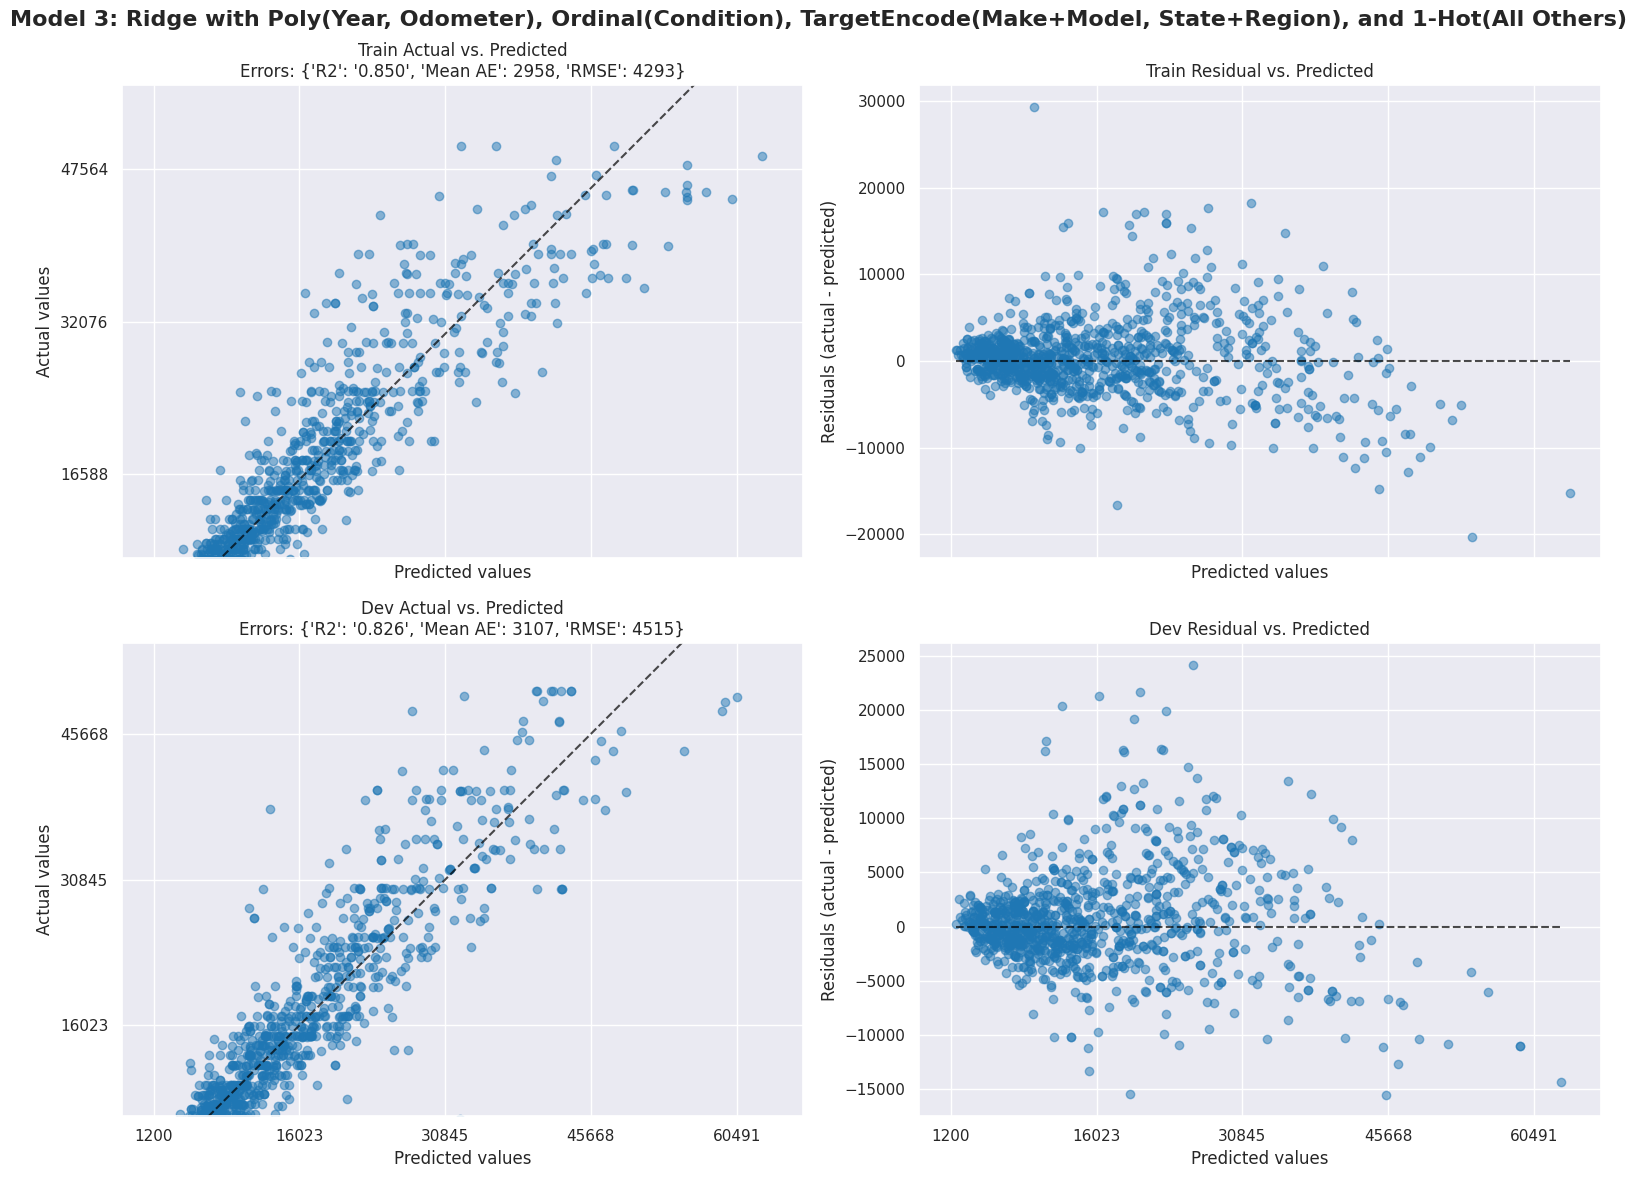

In [59]:
best_model3 = grid_search_and_plot(
    estimator=model3,
    param_grid=ttr_param_grid,
    description="Model 3: Ridge with Poly(Year, Odometer), Ordinal(Condition), TargetEncode(Make+Model, State+Region), and 1-Hot(All Others)",
)

### Analysis

After adding the remainder of the categorical features and a power transformer on the output, the model has gotten quite a bit better
- It's now within **5%** of the requirement

# Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

>At this stage in the project you have built one or more models that appear to have high quality, from a data analysis perspective. Before proceeding to final deployment of the model, it is important to more thoroughly evaluate the model, and review the steps executed to construct the model, to be certain it properly achieves the business objectives. A key objective is to determine if there is some important business issue that has not been sufficiently considered. At the end of this phase, a decision on the use of the data mining results should be reached.

Overall I think the modeling has succeeded in producing a reasonable estimate. If a candidate dealer were using this model, they could estimate, on average, within about $3,000 of the actual price. One useful thing at this point is to understand what features matter, and which do not.

## Feature Importance

In [60]:
def make_permutation_importance_DataFrame(
    estimator: Pipeline,
    X: pd.DataFrame,
    y: pd.Series,
    **permutation_importance_kwargs: dict,
) -> pd.DataFrame:
    # Compute the importances
    pi = permutation_importance(
        estimator,
        X,
        y,
        **permutation_importance_kwargs,
    )

    # Make a data frame of the importances, ordered from lowest to highest
    # mean importance per feature.
    df = pd.DataFrame(pi.importances.T, columns=X.columns).iloc[
        :, np.argsort(pi.importances_mean)
    ]

    # Keep only the non-zero importances. Features that were passed to the model
    # but not used by any column transformer are identically zero.
    return df.loc[:, df.mean() != 0.0]

In [61]:
# Importance per feature
df_pi = make_permutation_importance_DataFrame(
    best_model3,
    X_train,
    y_train,
    random_state=42,
    n_repeats=10,
)

df_pi.head()

,size,paint_color,transmission,condition,state-region,title_status,drive,type,cylinders,fuel,odometer,make-model,year
0,0.000399,0.001096,0.003711,0.004031,0.005891,0.014709,0.024674,0.041056,0.074088,0.081446,0.139923,0.148970,0.295567
1,0.000635,0.000680,0.002921,0.004088,0.005612,0.013462,0.026469,0.040991,0.075157,0.079707,0.137382,0.146317,0.297534
2,0.000659,0.001014,0.002885,0.005191,0.006181,0.013215,0.026244,0.038984,0.072721,0.079535,0.143123,0.146316,0.301014
3,0.000653,0.001090,0.002849,0.004502,0.005808,0.013668,0.026633,0.039294,0.073845,0.081768,0.138565,0.150202,0.292897
4,0.000858,0.000855,0.003251,0.004279,0.005899,0.015033,0.027342,0.039537,0.076671,0.082475,0.135687,0.153958,0.295787


### As a pie chart

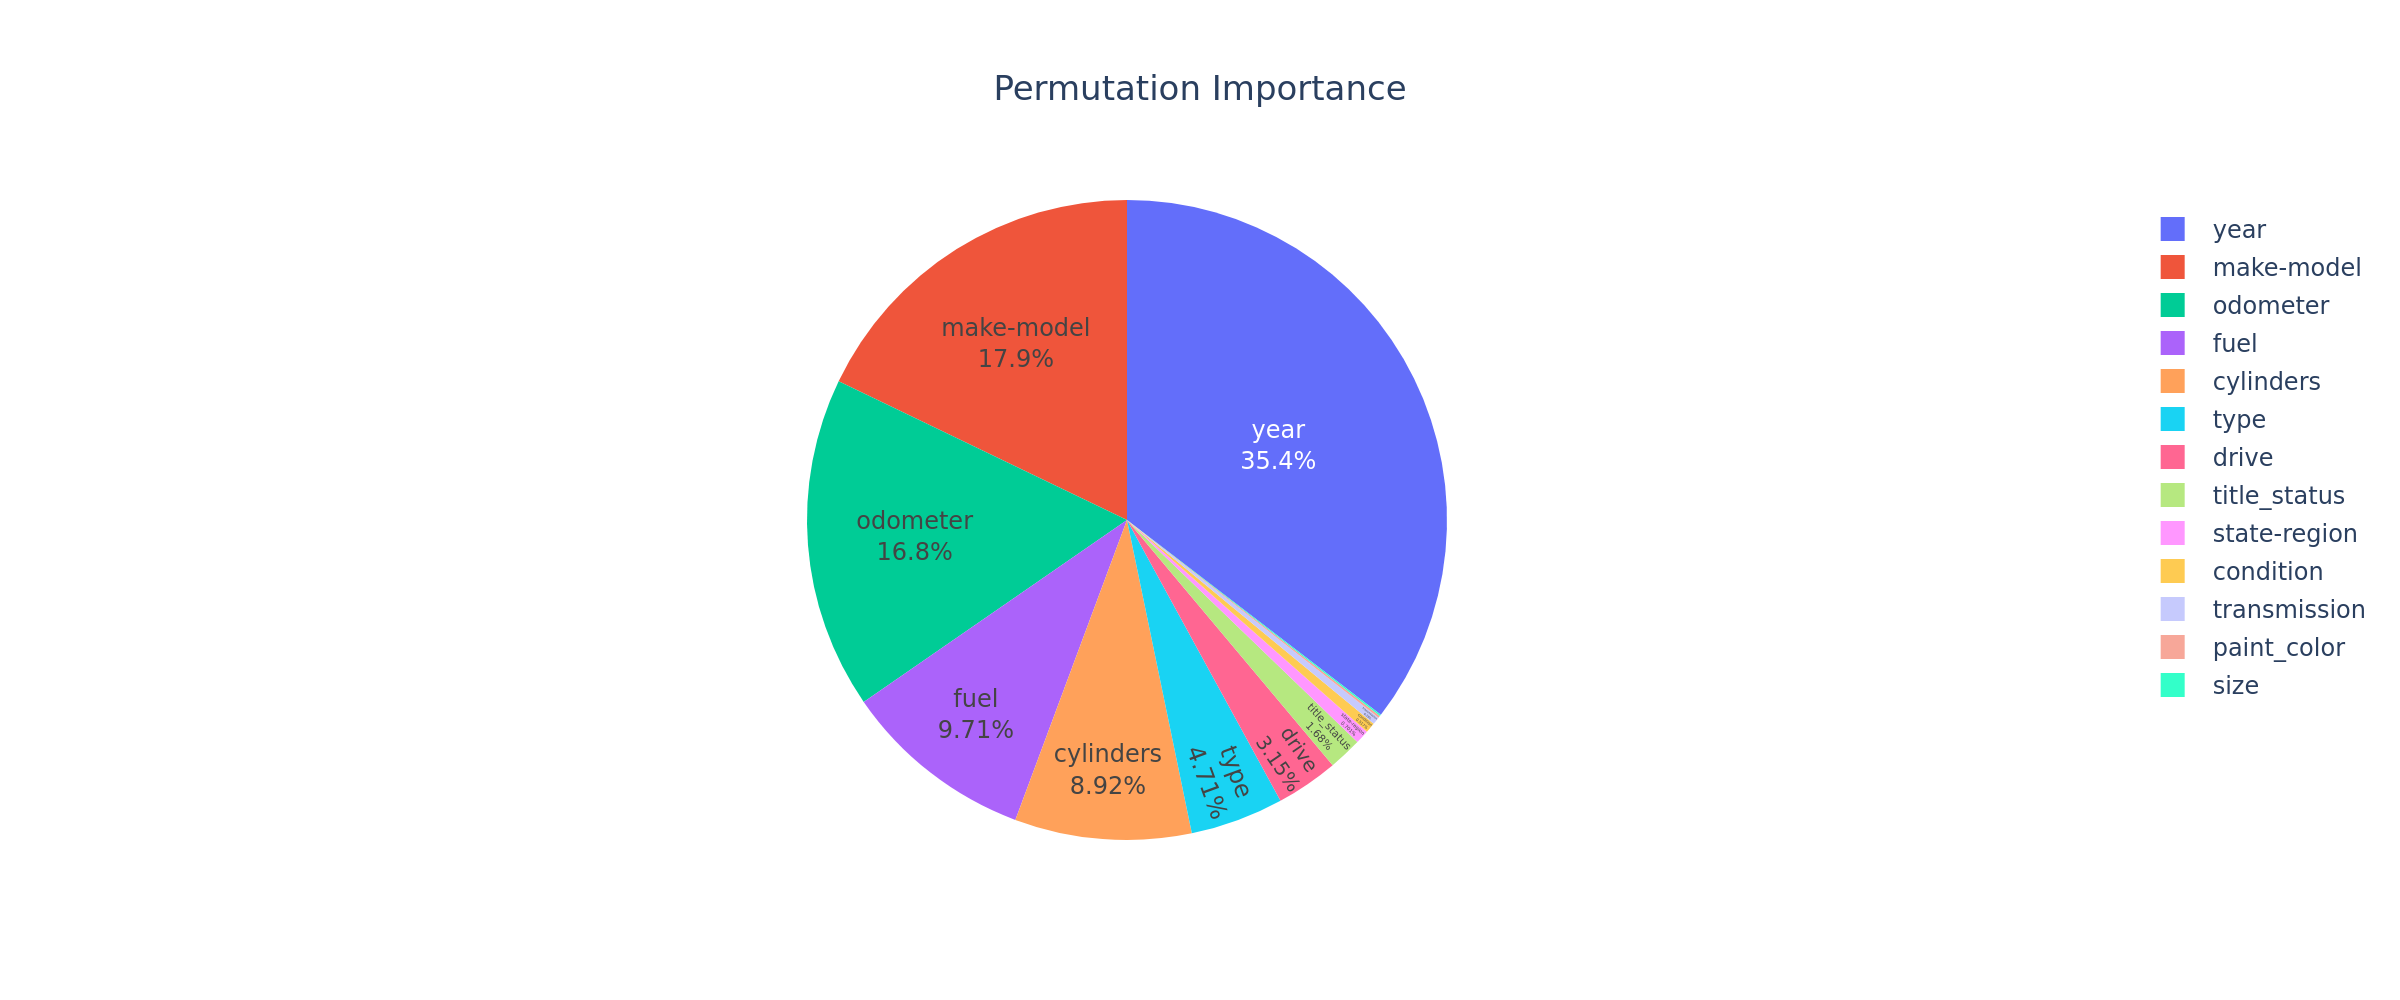

In [62]:
Image(
    px.pie(
        df_pi.describe().transpose(),
        names=df_pi.columns,
        values="mean",
        title="Permutation Importance",
        height=500,
    )
    .update_traces(textposition="inside", textinfo="percent+label")
    .update_layout(title_x=0.5)
    .to_image(format="png", width=1200, scale=2)
)

### As a bar chart

I couldn't decide which was easier to understand, so I showed them both. The values are different in the bar than in the pie because
- The pie shows percentage per feature out of 100
- The bar shows the most important feature as 100, and all others relative to that

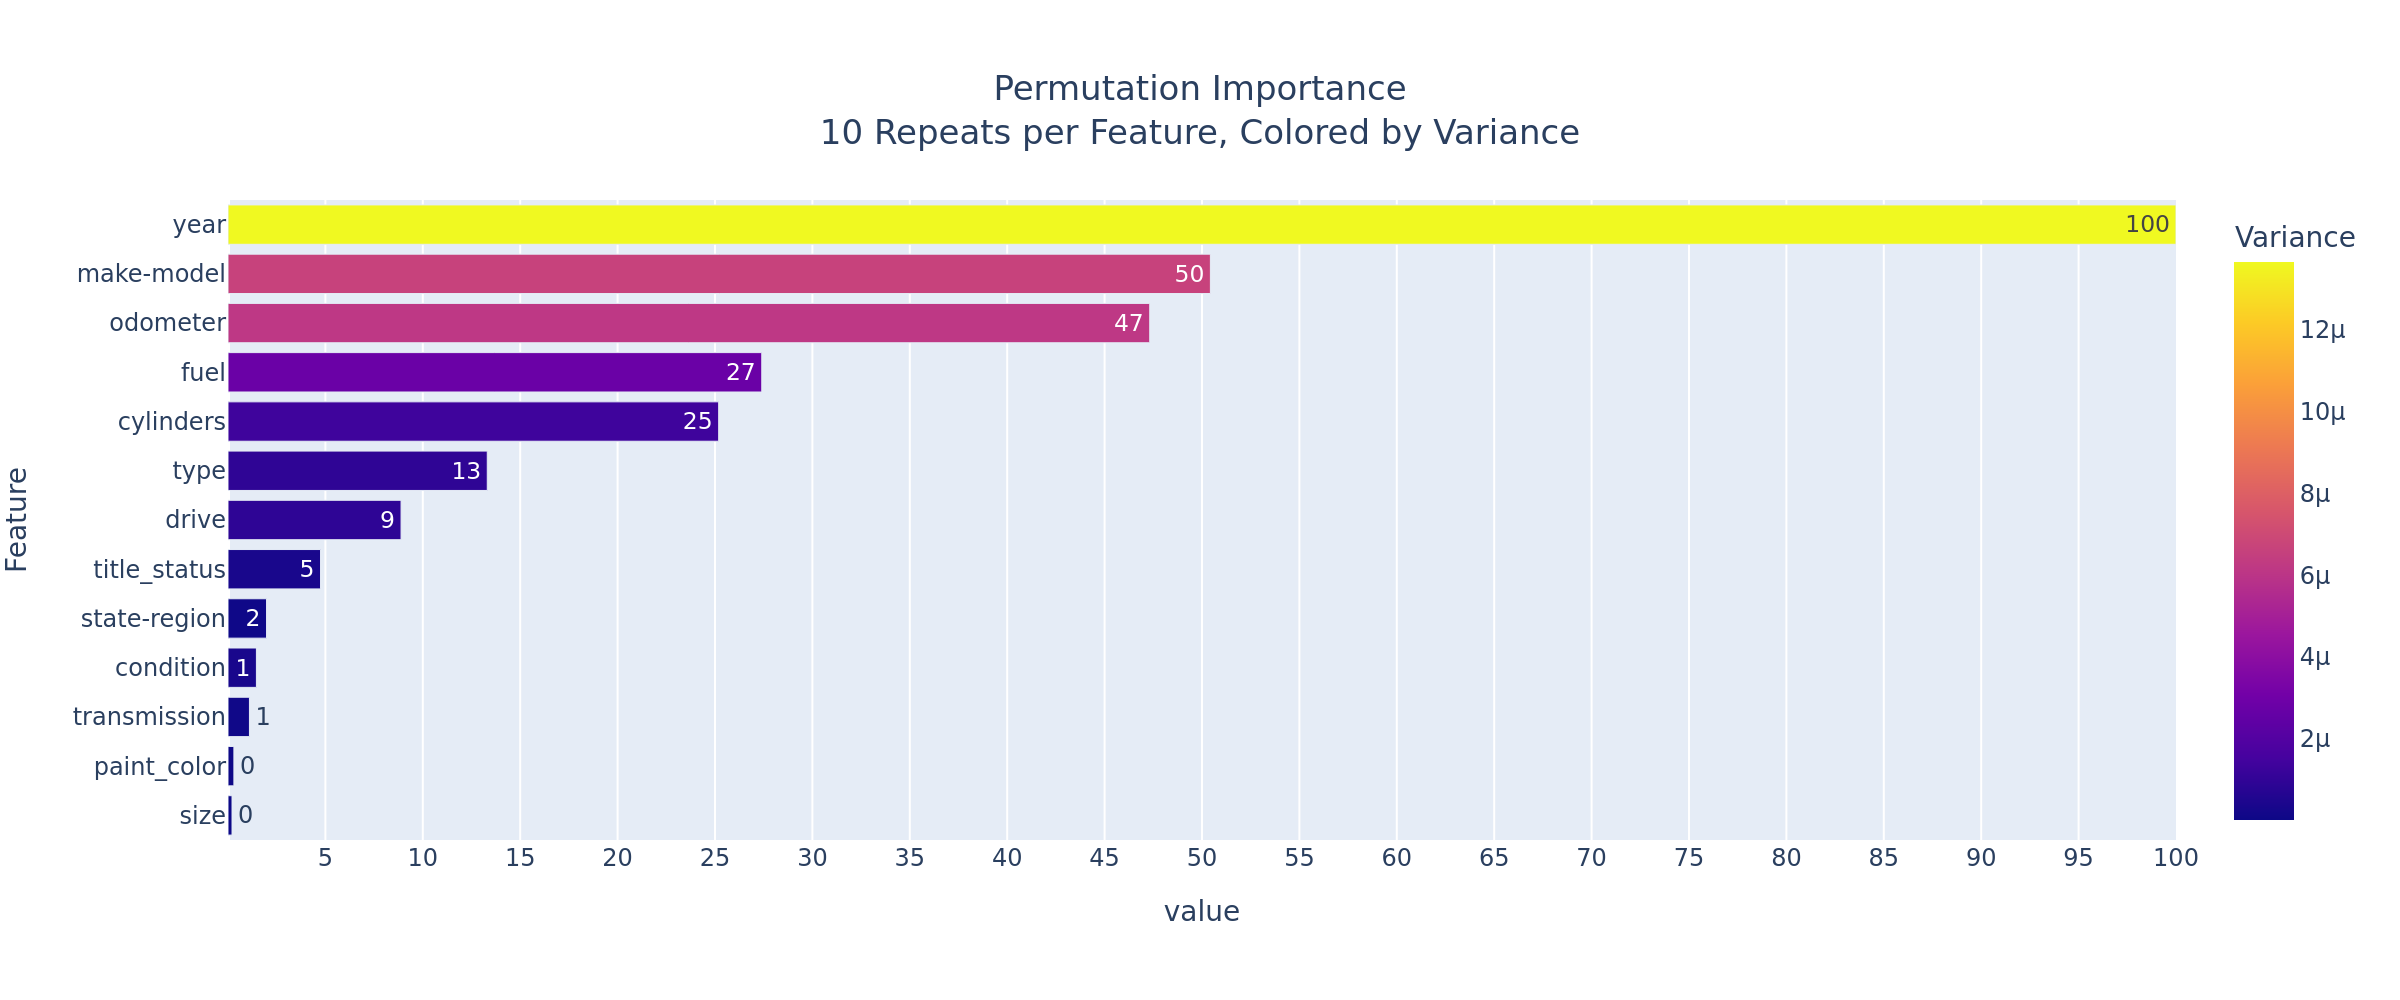

In [63]:
Image(
    px.bar(
        data_frame=df_pi.mean() / df_pi.mean()[-1] * 100.0,
        color=df_pi.var(),
        orientation="h",
        title="Permutation Importance<br>%d Repeats per Feature, Colored by Variance"
        % len(df_pi),
        height=500,
        text_auto="d",
        labels={
            "x": "Permutation Importance, as a Percentage of Importance of <b>%s</b>"
            % df_pi.columns[-1],
            "index": "Feature",
            "color": "Variance",
        },
    )
    .update_layout(title_x=0.5)
    .update_traces(textangle=0)
    .update_xaxes(tickvals=list(range(5, 105, 5)), range=[0, 100])
    .to_image(format="png", width=1200, scale=2)
)

The permutation importance scores are consistent to an extent, with common experience, where the vehicle's age and mileage constitute a large part of its price.
- One surprise is the relatively low importance of both condition and title status, which seems inconsistent with real-world experience
- But more than 95% of the title status is clean
    - So while important in the real world, the data set had almost no representation of status other than clean
- The condition was simiarly heavily constituted of excellent, good, and like new vehicles (again, more than 95%)

In [64]:
X["condition"].value_counts() / len(X) * 100.0

condition
excellent    55.735636
good         30.843574
like new     11.683826
fair          1.272003
new           0.381933
salvage       0.083029
Name: count, dtype: float64

In [65]:
X["title_status"].value_counts() / len(X) * 100.0

title_status
clean         96.273663
rebuilt        2.547326
salvage        0.767187
lien           0.398539
missing        0.009963
parts only     0.003321
Name: count, dtype: float64

# Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

>Creation of the model is generally not the end of the project. Usually, the knowledge gained will need to be organized and presented in a way that the customer can use it. Depending on the requirements, the deployment phase can be as simple as generating a report or as complex as implementing a repeatable data mining process. In many cases it will be the user, not the data analyst, who will carry out the deployment steps. In any case, it is important to understand up front what actions will need to be carried out in order to actually make use of the created models.

## Results

The modeling thus far did not meet the derived requirement. The best performance seen thus far has been **$3,150**, so although we failed to meet the requirement, we got pretty close. The client can use the performance against this requirement to build in sufficient margin per transaction such that they obtain profitable sales.

The modeling showed that the 3 most important features are
- The vehicle's year
- Mileage
- Make and model

Also important, but to a lesser extent, are the vehicle's fuel type and engine size (number of cylinders).

The size feature appears unimportant. Does that mean people do not care what size the vehicle is? I think not. I think what it means is that size is a redundant feature, given that a make + model feature fully describe size (i.e., there are not both large and small Ford F-150 models).

## Key Findings

The least important feature was paint color, meaning a client need not be concerned about which color vehicles to offer for sale, as the color had virtually no influence on the price.

The two most common models are pickup trucks, the Ford F-150 and Chevrolet Silverado 1500. The dealers can offer those models and be confident they will appeal to a large number of people. In fact, among the top 10 most commonly sold vehicles, 9 of the 10 were trucks.

The dealer could probably offer nothing but pickup trucks and make plenty of sales.

On the opposite end of the scale, several more expensive European brands were the least commonly sold, including Land Rover, Aston Martin, and Ferrari. Offering these vehicles for sale will appeal to a far narrower audience and may sit for extended periods of time on dealer lots.

## Next Steps and Recommendations

The most import next step is a meeting with the client to clarify what their true intent is. The request stated that the client wants to fine tune their inventory, but, fine tune it in what way?

Possibilities include
- To find the most commonly traded vehicles
- The most expensive vehicles
- Vehicles with the slowest depreciation
- To address a lower-income segment
- etc...

One approach is to choose a slice of the car market to operate in, such as lower-priced domestic manufacturers. If that were the client's objective, the modeling could be specialized to that slice. But maybe the client has already chosen a slice - knowing that would focus the modeling and enhance its accuracy and relevance to their requirements.

Beyond that, another step is to go over these findings with the candidate dealers and understand the suitability of the requirement, and more importantly, the model's performance against it. It might be good enough as is, or it may need additional refinement, in terms of either the model's performance against the requirement, or the requirement itself.